<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/Siamese_neural_network_for_BioASQ_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Find complex answers to medical questions




# Overall Task Review

You will work on a task of "query-focused summarisation" on medical questions where the goal is, given a medical question and a list of sentences extracted from relevant medical publications, to determine which of these sentences from the list can be used as part of the answer to the question. Assignment 3 is divided into two parts. Part 1 will help you get familar with the data, and Part 2 requires you to implement deep neural networks.

We will use data that has been derived from the **BioASQ challenge** (http://www.bioasq.org/), after some data manipulation to make it easier to process for this assignment. The BioASQ challenge organises several "shared tasks", including a task on biomedical semantic question answering which we are using here. The data are in the file `bioasq10_labelled.csv`, which is part of the zip file provided. Each row of the file has a question, a sentence text, and a label that indicates whether the sentence text is part of the answer to the question (1) or not (0).

# Data Review

The following code uses pandas to store the file `bioasq10_labelled.csv` in a data frame and show the first rows of data. For this code to run, first you need to unzip the file `data.zip`:

In [ ]:


from keras.layers import LSTM, SimpleRNN

import random
random.seed(1234)

from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text as TT
import tensorflow.keras.backend as K
from keras.models import Model, Sequential
from keras.layers import  Input, Embedding, LSTM, Bidirectional, Dense, Lambda
from keras.initializers import Constant
import pandas as pd
import numpy as np


The columns of the CSV file are:

* `qid`: an ID for a question. Several rows may have the same question ID, as we can see above.
* `sentid`: an ID for a sentence.
* `question`: The text of the question. In the above example, the first rows all have the same question: "Is Hirschsprung disease a mendelian or a multifactorial disorder?"
* `sentence text`: The text of the sentence.
* `label`: 1 if the sentence is a part of the answer, 0 if the sentence is not part of the answer.

# Now Let's get started for the Part 2 tasks

Use the provided files `training.csv`, `dev_test.csv`, and `test.csv` in the data.zip file for all the tasks below.

# Task 1 (5 marks): Simple Siamese NN

Implement a simple TensorFlow-Keras neural model that has the following sequence of layers:

1. An input layer that will accept the tf.idf of triplet data. The input of Siamese network is a triplet, consisting of anchor (i.e., the question), positive answer, negative answer.
2. 3 hidden layers and a relu activation function. You need to determine the size of the hidden layers.
3. Implement a class that serves as a distance layer. It returns the squared Euclidean distance between anchor and positive answer, as well as that between anchor and negative answer
4. Implement a function that prepares raw data in csv files into triplets. Note that it is important to keep the similar number of positive pairs and negative pairs. For example, if a question has 10 anwsers, then we at most can have 10 positive pairs and it is good to associate this question with 10~20 negative sentences.


Train the model with the training data and use the `dev_test` set to determine a good size of the hidden layer.

With the model that you have trained, implement a summariser that returns the $n$ sentences with highest predicted score. Use the following function signature:

```{python}
def nn_summariser(csvfile, questionids, n=1):
   """Return the IDs of the n sentences that have the highest predicted score.
      The input questionids is a list of question ids.
      The output is a list of lists of sentence ids
   """

```

Report the final results using the test set. Remember: use the test set to report the final results of the best system only.

The breakdown of marks is as follows:

* **1 mark** if the NN model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes input to the model correctly.
* **1 mark** if the code returns the IDs of the $n$ sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the hidden layer. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

#### Data preprocessing:

- In this part we implement a function that prepares raw data in csv files into triplets by creating a function random_triplet_generator.We keep the exact same number of positive pairs and negative pairs:

In [ ]:
def random_triplet_generator(x):
  # we create a function for preparing triplets with set of anchor,positive and negative texts.
  data = pd.read_csv(x)
  positive_data=data[data["label"]==1]                   #this part is mainly for anchor and the positive part.
  a_input=positive_data["question"].to_list()
  p_input=positive_data["sentence text"].to_list()

  a_input=np.array(a_input)
  p_input=np.array(p_input)

  negative_data=data[data["label"]==0]                 #this part is mainly for negative part.
  n_input= negative_data["sentence text"].to_list()
  n_input=np.array(n_input)
  import random

  random.seed(10)
  ind = [i for i in range(len(a_input))]                # we create two index lists ind and ind_2 to randomly shuffle the data for preventing overfitting
  random.shuffle(ind)

  random.seed(1212)
  ind_2 = [i for i in range(len(n_input))]
  random.shuffle(ind_2)


  a_input=a_input[ind].tolist()                       #  These are the randomly triplet set we created
  n_input=n_input[ind_2].tolist()
  p_input=p_input[ind].tolist()

  return (a_input,p_input,n_input[0:len(a_input)])   #we need three pairs of data the same length.#

# this is the triplet data set with the same length of both positive and  negative texts



In [ ]:
a_input,p_input,n_input=random_triplet_generator('training.csv')                   #we created a set of triplet in train,dev_test and test sets
a_input_test,p_input_test,n_input_test=random_triplet_generator('dev_test.csv')
a_input_test2,p_input_test2,n_input_test2=random_triplet_generator('test.csv')

### tf.idf vector:
- We create the tf.idf of triplet data for our train,set and dev_set :

In [ ]:

MAX_LEN=7000               #we only use the first MAX_LEN numbers of  higheest tfidf score to train our models
#EPOCH=9
batch_size = 40           #set our batch size

from tkinter import Text

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer         #



tfidf=TfidfVectorizer(stop_words="english",max_features=MAX_LEN)      # We convert into tfidf for each questions and answers
#firstly we create the TfidfVectorizer object with max_features

tfidf.fit(a_input+p_input+n_input)           #we fit the tfidf


a_input=tfidf.transform(a_input).toarray()                  #convert our questions and answers triplet into tfidf vectors
n_input=tfidf.transform(n_input).toarray()
p_input=tfidf.transform(p_input).toarray()

a_input_test=tfidf.transform(a_input_test).toarray()
n_input_test=tfidf.transform(n_input_test).toarray()
p_input_test=tfidf.transform(p_input_test).toarray()

a_input_test2=tfidf.transform(a_input_test2).toarray()
n_input_test2=tfidf.transform(n_input_test2).toarray()
p_input_test2=tfidf.transform(p_input_test2).toarray()




#### We create our model with the requirement:

- The input of Siamese network is a triplet, consisting of anchor (i.e., the question), positive answer, negative answer.
- 3 hidden layers and a relu activation function.
- Implement a class that serves as a distance layer. It returns the squared Euclidean distance between anchor and positive answer, as well as that between anchor and negative answer

In [ ]:
first_sent_in_a = Input(shape=(MAX_LEN,))   #we create the input with the max_len input shape to fit our model
second_sent_in_p = Input(shape=(MAX_LEN,))
third_sent_in_n = Input(shape=(MAX_LEN,))

from keras.models import Model, Sequential
import tensorflow as tf
from keras.layers import  Input, Embedding, LSTM, Bidirectional, Dense, Lambda
from tensorflow.keras.layers import Layer

def siamese_network_generator(x,y,z):  #we create a function for building the siamese_network with 3 inputs of the hidden layers
    first_sent_in_a = Input(shape=(MAX_LEN,))   #we create the input with the max_len input shape to fit our model
    second_sent_in_p = Input(shape=(MAX_LEN,))
    third_sent_in_n = Input(shape=(MAX_LEN,))


    model = Sequential([
      Dense(x, activation='relu'),
        Dense(y, activation='relu'),     #we have three hidden layers into the model
         Dense(z, activation='relu')
    ])

    encoded_1 = model(first_sent_in_a)         #these are the output where the datas passed through 3 hidden layers
    encoded_2 = model(second_sent_in_p)
    encoded_3 = model(third_sent_in_n)


    class distance_layer(Layer):   #create a distance layer as required


        def __init__(self, **kwargs):
            super().__init__(**kwargs)   #we need inheritance from the superclass layer.

        def call(self, anchor, positive, negative):
            ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)    #we caluclate the distance between the lists of positive(negative) and anchor vector
            an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
            return (ap_distance, an_distance)  #Returns the squared Euclidean distance between anchor and positive answer, as well as that between anchor and negative answer


    loss_layer = distance_layer()(encoded_1, encoded_2, encoded_3)  #this is the output

    siamese_network = Model([first_sent_in_a, second_sent_in_p, third_sent_in_n], loss_layer)  #we define our siamese_network here

    return siamese_network

In [ ]:
siamese_network=siamese_network_generator(53,32,32)

siamese_network.summary()  #this is an example of how we create the layers of this model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 7000)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 7000)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 7000)]       0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           373837      ['input_4[0][0]',                
                                                                  'input_5[0][0]',            

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses

from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet


class SiameseModel(Model):
# next we define our custom model class as our task is not traditional classification task
#there are lot of thing needed to be changed
  def __init__(self, siamese_network, margin=0.00000000000000000005):   #we choose such value;if the margin value is too large,the lost will not decrease after long period.
    super().__init__()
    self.siamese_network = siamese_network                                              # We create a build and create those object
    self.loss_tracker = metrics.Mean(name="loss")                  #We define our own metrics with the loss function "triplet_lost"  we define below
    self.margin = margin                                          #this is the margin value defined for our triplet loss
  def call(self, inputs):
    return self.siamese_network(inputs)
  @tf.function
  def train_step(self, data):                         #we define our custom training step with trainable_weights
    with tf.GradientTape() as tape:
        loss = self.triplet_lost(data)
        trainable_vars = self.siamese_network.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(                                     #we use gradient descent to keep track of each steps
            zip(gradients, trainable_vars)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}                           # return the loss for each steps
  @tf.function
  def test_step(self, data):
        loss = self.triplet_lost(data)
                                                                                    #we do the same thing for test step
        self.loss_tracker.update_state(loss)
        return {"loss_3": self.loss_tracker.result()}                             #the loss function loss_3 is for triplet validation dataset or test set (depended on situation)
  @tf.function
  def triplet_lost(self, data):


        ap_distance, an_distance = self.siamese_network(data)                  # we defined the triplet loss fucntion inside our custom fit

        loss=(tf.maximum(ap_distance - an_distance + self.margin, 0.0))
        loss=tf.reduce_sum(loss,0)

        return loss
  @property
  def metrics(self):

    return [self.loss_tracker]                              #we need our loss tracker

          #print out the detail of model we created


#### Finding the best hyperparamters

- In this part we search for different input of parameters and find the best paramters for least validation loss

- to simplify the process,we choose different hidden sizes to test the performance but we use the same number of hidden sizes in all 3 hidden layers and we set a fix learning rate with a small margin value(because the validation lost didnt go down after lone period)

- We set very small margins due to higher one gives no result.we just make it simple by looking at whether ap_distance is smaller than an_distance only

In [ ]:
from tensorflow.keras import callbacks
# we set a  function evluate the validation loss by puting different hyperparamters
def validation_evaluation(num_1,num_2,num_3,learning_rate,alpha):   #this function gives a input of parameters for each layers,learning rate and margin values
  siamese_model = SiameseModel(siamese_network_generator(num_1,num_2,num_3),alpha)
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate))
  callback = callbacks.EarlyStopping(monitor='loss',patience=2)
  siamese_model.fit([a_input, p_input,n_input],epochs=10, batch_size = 80,validation_data=[a_input_test[0:1000], p_input_test[0:1000],n_input_test[0:1000]],callbacks=[callback])
  return (siamese_model.evaluate([a_input_test,p_input_test,n_input_test],batch_size = 80),[num_1,num_2,num_3,learning_rate,alpha]) #the output is a the evaluation score
# we use 1000 datas for our validation set because it involved approxmiately 1/10 of the training data~

In [ ]:
# we have three trial with different hyperparameters
score_list=[]                         # We want to see determine best performance of each model
for i in range(16,256,16):    #to be simple: I only use the same hyperparamters for each layers #we have done for 10 different numbers
  score_list.append(validation_evaluation(i,i,i,0.005,0.000000000005))

#set very small margins due to higher one gives no result #we just make it simple by looking at
  #if ap_distance is smaller than an_distance only

Epoch 1/10
143/143 [==============================] - 1s 7ms/step - loss: 1.3027e-04 - val_loss_3: 2.1970e-08
Epoch 2/10
143/143 [==============================] - 1s 4ms/step - loss: 4.2398e-06 - val_loss_3: 4.8059e-07
Epoch 3/10
143/143 [==============================] - 1s 4ms/step - loss: 5.9712e-06 - val_loss_3: 6.5951e-07
Epoch 4/10
143/143 [==============================] - 1s 4ms/step - loss: 2.5449e-07 - val_loss_3: 9.3379e-09
Epoch 5/10
143/143 [==============================] - 1s 4ms/step - loss: 1.2284e-08 - val_loss_3: 4.7572e-09
Epoch 6/10
143/143 [==============================] - 1s 4ms/step - loss: 6.9285e-09 - val_loss_3: 2.9484e-09
Epoch 7/10
143/143 [==============================] - 1s 4ms/step - loss: 4.5327e-09 - val_loss_3: 2.3696e-09
Epoch 8/10
143/143 [==============================] - 1s 4ms/step - loss: 3.3799e-09 - val_loss_3: 1.7987e-09
Epoch 9/10
143/143 [==============================] - 1s 4ms/step - loss: 2.5632e-09 - val_loss_3: 1.4073e-09
Epoch 10/1

143/143 [==============================] - 1s 7ms/step - loss: 6.1584e-04 - val_loss_3: 9.8262e-06
Epoch 2/10
143/143 [==============================] - 1s 5ms/step - loss: 8.5710e-06 - val_loss_3: 3.3007e-06
Epoch 3/10
143/143 [==============================] - 1s 5ms/step - loss: 5.2835e-06 - val_loss_3: 2.9161e-06
Epoch 4/10
143/143 [==============================] - 1s 5ms/step - loss: 2.5876e-06 - val_loss_3: 2.4903e-06
Epoch 5/10
143/143 [==============================] - 1s 5ms/step - loss: 8.2848e-07 - val_loss_3: 2.3758e-06
Epoch 6/10
143/143 [==============================] - 1s 5ms/step - loss: 1.2217e-07 - val_loss_3: 1.6091e-06
Epoch 7/10
143/143 [==============================] - 1s 5ms/step - loss: 5.9358e-08 - val_loss_3: 1.3786e-06
Epoch 8/10
143/143 [==============================] - 1s 5ms/step - loss: 2.9370e-08 - val_loss_3: 1.2094e-06
Epoch 9/10
143/143 [==============================] - 1s 5ms/step - loss: 2.5029e-08 - val_loss_3: 1.1888e-06
Epoch 10/10
49/49 [==

143/143 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss_3: 1.0657e-04
Epoch 2/10
143/143 [==============================] - 1s 7ms/step - loss: 4.7482e-05 - val_loss_3: 3.2508e-05
Epoch 3/10
143/143 [==============================] - 1s 8ms/step - loss: 1.1120e-05 - val_loss_3: 2.7458e-05
Epoch 4/10
143/143 [==============================] - 1s 8ms/step - loss: 4.5574e-06 - val_loss_3: 2.6226e-05
Epoch 5/10
143/143 [==============================] - 1s 7ms/step - loss: 3.0284e-06 - val_loss_3: 2.5769e-05
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 4.0897e-06 - val_loss_3: 3.4624e-05
Epoch 7/10
49/49 [==============================] - 0s 4ms/step - loss_3: 8.3092e-05
Epoch 1/10
143/143 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss_3: 3.8126e-05
Epoch 2/10
143/143 [==============================] - 1s 7ms/step - loss: 1.9276e-05 - val_loss_3: 1.2067e-05
Epoch 3/10
143/143 [==============================] -

143/143 [==============================] - 1s 9ms/step - loss: 1.2761e-05 - val_loss_3: 1.0435e-04
Epoch 5/10
143/143 [==============================] - 1s 8ms/step - loss: 9.5911e-06 - val_loss_3: 1.4970e-04
Epoch 6/10
143/143 [==============================] - 1s 9ms/step - loss: 2.7669e-05 - val_loss_3: 1.2963e-04
Epoch 7/10
49/49 [==============================] - 0s 4ms/step - loss_3: 2.4980e-04
Epoch 1/10
143/143 [==============================] - 2s 13ms/step - loss: 0.0036 - val_loss_3: 2.7351e-04
Epoch 2/10
143/143 [==============================] - 1s 10ms/step - loss: 9.4317e-05 - val_loss_3: 1.6399e-04
Epoch 3/10
143/143 [==============================] - 1s 9ms/step - loss: 2.5769e-05 - val_loss_3: 2.0509e-04
Epoch 4/10
143/143 [==============================] - 1s 9ms/step - loss: 2.8032e-05 - val_loss_3: 3.0026e-04
Epoch 5/10
49/49 [==============================] - 0s 4ms/step - loss_3: 4.9607e-04
Epoch 1/10
143/143 [==============================] - 4s 18ms/step - loss

Epoch 5/10
49/49 [==============================] - 1s 12ms/step - loss_3: 0.0014
Epoch 1/10
143/143 [==============================] - 3s 21ms/step - loss: 0.0053 - val_loss_3: 3.2440e-04
Epoch 2/10
143/143 [==============================] - 2s 14ms/step - loss: 8.6013e-05 - val_loss_3: 1.8436e-04
Epoch 3/10
143/143 [==============================] - 2s 15ms/step - loss: 2.9063e-05 - val_loss_3: 2.1295e-04
Epoch 4/10
143/143 [==============================] - 2s 15ms/step - loss: 1.2717e-05 - val_loss_3: 1.7761e-04
Epoch 5/10
143/143 [==============================] - 2s 14ms/step - loss: 2.4887e-05 - val_loss_3: 2.4393e-04
Epoch 6/10
49/49 [==============================] - 0s 7ms/step - loss_3: 3.5721e-04
Epoch 1/10
143/143 [==============================] - 3s 16ms/step - loss: 0.0092 - val_loss_3: 0.0013
Epoch 2/10
143/143 [==============================] - 2s 14ms/step - loss: 3.3791e-04 - val_loss_3: 8.0795e-04
Epoch 3/10
143/143 [==============================] - 2s 14ms/step -

143/143 [==============================] - 2s 14ms/step - loss: 1.2201e-04 - val_loss_3: 0.0011
Epoch 5/10
143/143 [==============================] - 2s 14ms/step - loss: 2.8762e-04 - val_loss_3: 0.0018
Epoch 6/10
49/49 [==============================] - 0s 5ms/step - loss_3: 0.0019
Epoch 1/10
143/143 [==============================] - 3s 15ms/step - loss: 0.0119 - val_loss_3: 0.0016
Epoch 2/10
143/143 [==============================] - 2s 14ms/step - loss: 4.2978e-04 - val_loss_3: 7.4762e-04
Epoch 3/10
143/143 [==============================] - 2s 17ms/step - loss: 1.2689e-04 - val_loss_3: 7.3903e-04
Epoch 4/10
143/143 [==============================] - 2s 16ms/step - loss: 8.8000e-05 - val_loss_3: 0.0011
Epoch 5/10
143/143 [==============================] - 2s 15ms/step - loss: 1.6671e-04 - val_loss_3: 0.0021
Epoch 6/10
49/49 [==============================] - 0s 5ms/step - loss_3: 0.0075
Epoch 1/10
143/143 [==============================] - 3s 18ms/step - loss: 0.0114 - val_loss_3: 

In [ ]:
minimum_lost=100000

for i , j in (score_list):   # we search for the best minimum losts with the best_praramters
  if i<minimum_lost:
    best_praramters=j
    minimum_lost=i

best_praramters     #we select the best hyperparameters from the value with minimum lost.

[16, 16, 16, 0.005, 5e-12]

#### we retrain the model using best hyperparameters and make prediction

In [ ]:
# retrain the model using best hyperparameters and make prediction

siamese_model = SiameseModel(siamese_network_generator(best_praramters[0],best_praramters[1],best_praramters[2]),0.005)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.005))
callback = callbacks.EarlyStopping(monitor='loss',patience=2)
siamese_model.fit([a_input, p_input,n_input],epochs=10, batch_size = 80,validation_data=[a_input_test[0:1000], p_input_test[0:1000],n_input_test[0:1000]],callbacks=[callback])
#We fit our model and run it

siamese_model.predict([a_input,p_input,n_input],batch_size=40)  #the output is supposed to be two set of distances

Epoch 1/10
143/143 [==============================] - 1s 6ms/step - loss: 0.1963 - val_loss_3: 0.2243
Epoch 2/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0398 - val_loss_3: 0.2653
Epoch 3/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss_3: 0.2864
Epoch 4/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss_3: 0.3192
Epoch 5/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss_3: 0.3441
Epoch 6/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss_3: 0.3566
Epoch 7/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss_3: 0.3588
Epoch 8/10
286/286 [==============================] - 1s 2ms/step


(array([0.01161807, 0.02046644, 0.00955711, ..., 0.00878781, 0.02620158,
        0.01148407], dtype=float32),
 array([0.0485378 , 0.07154507, 0.06493345, ..., 0.10847147, 0.1692521 ,
        0.0499534 ], dtype=float32))

In [ ]:
from sklearn.metrics import f1_score
import numpy as np



#### Implement a summariser that returns the  n sentences with highest predicted score.

 - Our code returns the IDs of the  n  sentences that have the highest prediction score in the given question.

In [ ]:
def nn_summariser(csvfile, questionids, n=1):
  qid_list=questionids   # The input questionids is a list of question ids.
  test_2 = pd.read_csv(csvfile)   #input file we want
  total=[]
  for qid in qid_list:
    anchorinput=list(test_2.loc[(test_2["qid"]==qid) & (test_2["sentid"]==0)]["question"])  # anchorinput is question with id qid

    positiveinput=list(test_2.loc[(test_2["qid"]==qid) & (test_2["sentid"]==0)]["sentence text"]) #it doesnt matter and I can fit with random object

    negativeinput=(list(test_2.loc[(test_2["qid"]==qid)]["sentence text"]))   #these are all answers relaed to this specific question id =qid(including those label 1 or 0)

    positiveinput=positiveinput*len(negativeinput)     #we need to increase the length until it matches other inputs
    anchorinput=anchorinput*len(negativeinput)         #we need to increase the length until it matches other inputs

    a_input=tfidf.transform(anchorinput).toarray()           #We transform those answers and question qid into array
    n_input=tfidf.transform(negativeinput).toarray()
    p_input=tfidf.transform(positiveinput).toarray()

    ap_distance_test,an_distance_test = siamese_model.predict([a_input,p_input,n_input],batch_size=40)
    #this an_distance gives us lists of questions with different predicted scores

    list(np.argsort(an_distance_test))    #only see one output which is enough in this task and we give the lists of sentence ids with highest predicted score
    total.append(list(np.argsort(an_distance_test))[0:n])  #return the list of n answer_index of this question id into the list and append into our final list
    #We do for every single qid and give the list of the list
  return total


In [ ]:
nn_summariser("test.csv",[6,3987,4220],4)  #our testing result  #here we use n=4

1/1 [==============================] - 0s 19ms/step


[[24, 28, 25, 7], [40, 45, 44, 38], [0, 5, 3, 6]]

#### We caluclate the F1 score:

In [ ]:
#lets make a list of lebals which allow us to caluclate the F1 score in test_score

def labels(x,n):
    test_3 = pd.read_csv(x)
    total_predict=[]
    total_true=[]
    for qid in list(test_3["qid"].unique())[0:n]:
      #uni_id=test_3.loc[(test_3["qid"]==qid)]

      anchorinput=list(test_3.loc[(test_3["qid"]==qid) & (test_3["sentid"]==0)]["question"])*len(test_3.loc[(test_3["qid"]==qid)])  ##e need to increase the length until it matches other inputs

      positiveinput=(list(test_3.loc[(test_3["qid"]==qid)]["sentence text"]))   #(positiveinput and negativeinput) can be the same(no difference)  #we use one set of distances only

      negativeinput=(list(test_3.loc[(test_3["qid"]==qid)]["sentence text"]))

      a_input=tfidf.transform(anchorinput).toarray()                       #transform into tfidfvector
      n_input=tfidf.transform(negativeinput).toarray()
      p_input=tfidf.transform(positiveinput).toarray()


      ap_distance_test,an_distance_test = siamese_model.predict([a_input,p_input,n_input],batch_size=40)  #we obtain a set of distances for each answers related to
      #the same question
      thershold=0.5  #this is out chosen thershold to caluclate the F1 score

      y_predict=list(ap_distance_test<thershold)       #predict label 1(0) when the distance is less(more) than thershold

      total_predict=total_predict+y_predict            #add the list of predict label for the same question into total_predict
      total_true=total_true+list(test_3.loc[(test_3["qid"]==qid)]["label"])    #add the list of ground label for the same question into true_total


    return (total_predict,total_true)  #turn both value for caluclating F1 score


In [ ]:
total_true_1,total_predict_1=labels("test.csv",50) #We use 50 random datas to calucluate our F1 score.



1/1 [==============================] - 0s 17ms/step


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

f1_score_1=f1_score(total_true_1, total_predict_1) #this is the final F1 score

- We will dicuss our results in the next part when we compare with task 2.

# Task 2 (5 marks): Recurrent NN

Implement a more complex Siamese neural network that is composed of the following layers:

* An embedding layer that generates embedding vectors of the sentence text with 35 dimensions.
* A LSTM layer. You need to determine the size of this LSTM layer, and the text length limit (if needed).
* 3 hidden layers and a relu activation function. You need to determine the size of the hidden layers.

Train the model with the training data, use the `dev_test` set to determine a good size of the LSTM layer and an appropriate length limit (if needed), and report the final results using the test set. Again, remember to use the test set only after you have determined the optimal parameters of the LSTM layer.

Based on your experiments, comment on whether this system is better than the systems developed in the previous tasks.

The breakdown of marks is as follows:

* **1 mark** if the NN model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes the sentence text to the model correctly. The documentation needs to explain what decisions had to be made to process long sentences. In particular, did you need to truncate the input text, and how did you determine the length limit?
* **1 mark** if the code returns the IDs of the *n* sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the LSTM layer (and length limit) and hidden layers. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

### Creating our tf.idf vector:
- We create the tf.idf of triplet data for our train,set and dev_set. Due to the runnning time becomes so low when we add a  LSTM layers and embeeding layers,we decide to use 300 words with highest tfidf score.

In [ ]:
MAX_LEN=300    #we only use the first MAX_LEN numbers of  higheest tfidf score to train our models
#EPOCH=9
batch_size = 40    #set our batch size

a_input,p_input,n_input=random_triplet_generator('training.csv')  #we created a set of triplet in train,dev_test and test sets
a_input_test,p_input_test,n_input_test=random_triplet_generator('dev_test.csv')
a_input_test2,p_input_test2,n_input_test2=random_triplet_generator('test.csv')

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()

tfidf=TfidfVectorizer(stop_words="english",max_features=MAX_LEN)      # We convert into tfidf for each questions and answers

tfidf.fit(a_input+p_input+n_input)  #we fit the tfidf


a_input=tfidf.transform(a_input).toarray()
n_input=tfidf.transform(n_input).toarray()       #convert our questions and answers triplet into tfidf vectors
p_input=tfidf.transform(p_input).toarray()

a_input_test=tfidf.transform(a_input_test).toarray()
n_input_test=tfidf.transform(n_input_test).toarray()
p_input_test=tfidf.transform(p_input_test).toarray()

a_input_test2=tfidf.transform(a_input_test2).toarray()
n_input_test2=tfidf.transform(n_input_test2).toarray()
p_input_test2=tfidf.transform(p_input_test2).toarray()




#### We create our model with the requirement:
-  An embedding layer that generates embedding vectors of the sentence text with 35 dimensions.
- A LSTM layer.we set the contraint of the input text with 300.
- 3 hidden layers and a relu activation function.

In [ ]:


from keras.models import Model, Sequential

from keras.layers import  Input, Embedding, LSTM, Bidirectional, Dense, Lambda
from tensorflow.keras.layers import Layer

#we create the input with the max_len input shape to fit our model

# add three layers(hidden one)

def siamese_network_generator(x,y,z,w):  #we create a function for building the siamese_network with 4 inputs of the hidden/LSTM layers
    embed_size=35
    first_sent_in_a = Input(shape=(MAX_LEN,))
    second_sent_in_p = Input(shape=(MAX_LEN,))
    third_sent_in_n = Input(shape=(MAX_LEN,))

    embedding_layer =  Embedding(input_dim=MAX_LEN+1, output_dim=embed_size, input_length=MAX_LEN, trainable=True)
#An embedding layer that generates embedding vectors of the sentence text with 35 dimensions.
#Max_len +1 : we might have some known words which are not in dataset.


    simpleLSTM = LSTM(units=w, return_sequences=False) #w is the units of LSTM
#A LSTM layer. You need to determine the size of this LSTM layer, and the text length limit (if needed).


    first_sent_encoded_a = simpleLSTM(embedding_layer(first_sent_in_a) )  #get representation for first sentense
    second_sent_encoded_p = simpleLSTM(embedding_layer(second_sent_in_p))
    third_sent_encoded_n = simpleLSTM(embedding_layer(third_sent_in_n))


    model = Sequential([
      Dense(x, activation='relu'),                        #we have three hidden layers into the model
        Dense(y, activation='relu'),
         Dense(z, activation='relu')
    ])

    encoded_1 = model(first_sent_encoded_a )
    encoded_2 = model(second_sent_encoded_p)    #these are the output where the datas passed through 3 hidden layers
    encoded_3 = model(third_sent_encoded_n)


    class TripletLossLayer(Layer):              #create a distance layer as required
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

        def call(self, anchor, positive, negative):
            ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
            an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)         #we need inheritance from the superclass layer.
            return (ap_distance, an_distance)
        #we caluclate the distance between the lists of positive(negative) and anchor vector
 #Returns the squared Euclidean distance between anchor and positive answer, as well as that between anchor and negative answer
    loss_layer = TripletLossLayer()(encoded_1, encoded_2, encoded_3)

    siamese_network = Model([first_sent_in_a, second_sent_in_p, third_sent_in_n], loss_layer)

    return siamese_network
 #we define our siamese_network here


class LSTMSiameseModel(Model):
# next we define our custom model class as our task is not traditional classification task
#there are lot of thing needed to be changed

    def __init__(self, siamese_network, margin=0.000000000000001):
        super().__init__()
        self.siamese_network = siamese_network   # We create a build and create those object
        self.margin = margin                     #We define our own metrics with the loss function "triplet_lost" we define below
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs) # #this is the margin value defined for our triplet loss
    #@tf.function
    def train_step(self, data):

        with tf.GradientTape() as tape: #we define our custom training step with trainable_weights
            loss = self.triplet_lost(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)  #we use gradient descent to keep track of each steps

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}   # return the loss for each steps
    #@tf.function
    def test_step(self, data):            #we do the same thing for test step
        loss = self.triplet_lost(data)
        self.loss_tracker.update_state(loss)
        return {"loss_3": self.loss_tracker.result()}
    #@tf.function
    def triplet_lost(self, data):         #the loss function loss_3 is for triplet validation dataset or test set (depended on situation)


        ap_distance, an_distance = self.siamese_network(data)   # we defined the triplet lost fucntion inside our custom fit

        loss=(tf.maximum(ap_distance - an_distance + self.margin, 0.0))


        return loss

    @property
    def metrics(self):
                                       #we need our loss tracker
        return [self.loss_tracker]

siamese_network=siamese_network_generator(26,26,26,36)
siamese_network.summary()                       #print out the detail of model we created


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_60 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 35)      10535       ['input_58[0][0]',               
                                                                  'input_59[0][0]',        

#### Finding the best hyperparamters

- In this part we search for different input of parameters and find the best paramters for least validation loss

- to simplify the process,we choose different hidden sizes to test the performance but we use the same number of hidden sizes in all 3 hidden layers and we set a fix learning rate with a small margin value(because the validation lost didnt go down after lone period)

- the w paramters in validation_evaluation is our LSTM hidden sizes



In [ ]:
from tensorflow.keras import callbacks
# we set a  function evluate the validation loss by puting different hyperparamters
def validation_evaluation_(num_1,num_2,num_3,learning_rate,alpha,w):   #this function gives a input of parameters for each layers,learning rate and margin values
  siamese_model = LSTMSiameseModel(siamese_network_generator(num_1,num_2,num_3,w),alpha)
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate))
  callback = callbacks.EarlyStopping(monitor='loss',patience=2)

  siamese_model.fit([a_input, p_input,n_input],epochs=10, batch_size = 80,validation_data=[a_input_test[0:1000], p_input_test[0:1000],n_input_test[0:1000]],callbacks=[callback])
  return (siamese_model.evaluate([a_input_test,p_input_test,n_input_test],batch_size = 80),[num_1,num_2,num_3,learning_rate,alpha]) #the output is a the evaluation score
  # we use 1000 data (approxmiate to be 1/10 of our our dataset)


In [ ]:
# we have three trial with different hyperparameters
score_list=[]                         # We want to see determine best performance of each model
for i in [16,32,64]:    #to be simple: I only use the same hyperparamters for each layers and we use different neurons w for LSTM layers
    for w in [16,32]:  #we choose a smaller values due to memory problem
        score_list.append((validation_evaluation_(i,i,i,0.005,0.000000000005,w),i,w)) #set very small margins due to higher one gives no result #we just make it simple by looking at
  #if ap_distance is smaller than an_distance only


Epoch 1/10
143/143 [==============================] - 22s 130ms/step - loss: 1.6104e-09 - val_loss_3: 7.2807e-11
Epoch 2/10
143/143 [==============================] - 12s 83ms/step - loss: 1.4789e-09 - val_loss_3: 8.0660e-10
Epoch 3/10
143/143 [==============================] - 12s 82ms/step - loss: 1.0844e-09 - val_loss_3: 7.5455e-11
Epoch 4/10
143/143 [==============================] - 12s 84ms/step - loss: 2.5434e-10 - val_loss_3: 1.2454e-11
Epoch 5/10
143/143 [==============================] - 12s 84ms/step - loss: 3.8459e-11 - val_loss_3: 7.0685e-12
Epoch 6/10
143/143 [==============================] - 12s 81ms/step - loss: 1.2017e-11 - val_loss_3: 5.6773e-12
Epoch 7/10
143/143 [==============================] - 12s 84ms/step - loss: 8.3344e-12 - val_loss_3: 5.2354e-12
Epoch 8/10
143/143 [==============================] - 12s 86ms/step - loss: 6.7443e-12 - val_loss_3: 5.0715e-12
Epoch 9/10
143/143 [==============================] - 12s 82ms/step - loss: 5.9690e-12 - val_loss_3: 5.

49/49 [==============================] - 2s 31ms/step - loss_3: 1.0964e-10
Epoch 1/10
143/143 [==============================] - 28s 173ms/step - loss: 1.3744e-08 - val_loss_3: 2.0267e-10
Epoch 2/10
143/143 [==============================] - 23s 162ms/step - loss: 6.2857e-09 - val_loss_3: 3.6003e-09
Epoch 3/10
143/143 [==============================] - 23s 163ms/step - loss: 4.9745e-09 - val_loss_3: 1.0914e-10
Epoch 4/10
143/143 [==============================] - 23s 164ms/step - loss: 1.0155e-08 - val_loss_3: 4.2470e-11
Epoch 5/10
49/49 [==============================] - 7s 121ms/step - loss_3: 1.3893e-08
Epoch 1/10
143/143 [==============================] - 34s 214ms/step - loss: 1.1393e-08 - val_loss_3: 6.4281e-09
Epoch 2/10
143/143 [==============================] - 28s 193ms/step - loss: 9.2724e-09 - val_loss_3: 6.5888e-10
Epoch 3/10
143/143 [==============================] - 27s 192ms/step - loss: 9.7651e-10 - val_loss_3: 9.6195e-10
Epoch 4/10
143/143 [===========================

In [ ]:
scored_list=[]
for i ,j ,k in score_list:
    scored_list.append((i[0],i[1][0],k))  #to make a clear list

In [ ]:
scored_list

[(4.993807884573487e-12, 16, 16),
 (3.509061485829079e-09, 16, 32),
 (9.369448966678462e-11, 32, 16),
 (1.2203935639831798e-08, 32, 32),
 (3.1017435286884165e-09, 64, 16),
 (1.2703317286977267e-09, 64, 32)]

In [ ]:
minimum_lost=100000

for i , j ,w in (scored_list):
  if i<minimum_lost:
    best_praramters=(j,w)
    minimum_lost=i      # we search for the best minimum losts with the best_praramters

print ("best_hidden parameters:",best_praramters[0],best_praramters[0],best_praramters[0])

print ("best_LSTM units:",best_praramters[1])

best_hidden parameters: 16 16 16
best_LSTM units: 16


#### we retrain the model using best hyperparameters and make prediction

In [ ]:
minimum_lost=100000

for i , j ,w in (scored_list):
  if i<minimum_lost:
    best_praramters=(j,w)
    minimum_lost=i      # we search for the best minimum losts with the best_praramters

best_praramters #this is the one we obatin
LSTMsiamese_model=LSTMSiameseModel(siamese_network_generator(best_praramters[0],best_praramters[0],best_praramters[0],best_praramters[1]),0.000000000005)

LSTMsiamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.005))
callback = callbacks.EarlyStopping(monitor='loss',patience=1)
LSTMsiamese_model.fit([a_input, p_input,n_input],epochs=10, batch_size = 80,validation_data=[a_input_test[0:1000], p_input_test[0:1000],n_input_test[0:1000]],callbacks=[callback])



#We fit our model and run it

LSTMsiamese_model.predict([a_input,p_input,n_input],batch_size=40)  #the output is supposed to be two set of distances

Epoch 1/10
143/143 [==============================] - 43s 274ms/step - loss: 1.0178e-08 - val_loss_3: 1.2687e-08
Epoch 2/10
143/143 [==============================] - 39s 274ms/step - loss: 6.4221e-09 - val_loss_3: 2.1514e-11
Epoch 3/10
286/286 [==============================] - 12s 38ms/step


(array([0.0000000e+00, 3.0253577e-15, 2.0832516e-08, ..., 0.0000000e+00,
        0.0000000e+00, 1.0580784e-07], dtype=float32),
 array([0.0000000e+00, 4.8017146e-15, 2.0832516e-08, ..., 0.0000000e+00,
        0.0000000e+00, 1.0579440e-07], dtype=float32))

In [ ]:
LSTMsiamese_model.predict([a_input_test, p_input_test,n_input_test],batch_size=40)  #some test inputs

97/97 [==============================] - 4s 40ms/step


(array([5.6066263e-15, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([5.6066263e-15, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32))

#### Implement a LSTMnn_summariser that returns the  n sentences with highest predicted score.

 - Our code returns the IDs of the  n  sentences that have the highest prediction score in the given question.

In [ ]:
def LSTMnn_summariser(csvfile, questionids, n=1):
  qid_list=questionids
  test_2 = pd.read_csv(csvfile)
  total=[]
  for qid in qid_list:
    anchorinput=list(test_2.loc[(test_2["qid"]==qid) & (test_2["sentid"]==0)]["question"])  #it doesnt matter and I can fit with random object

    positiveinput=list(test_2.loc[(test_2["qid"]==qid) & (test_2["sentid"]==0)]["sentence text"])
    #these are all answers relaed to this specific question id =qid(including those label 1 or 0)

    negativeinput=(list(test_2.loc[(test_2["qid"]==qid)]["sentence text"]))

    positiveinput=positiveinput*len(negativeinput)   #we need to increase the length until it matches other inputs
    anchorinput=anchorinput*len(negativeinput)       #we need to increase the length until it matches other inputs

    a_input=tfidf.transform(anchorinput).toarray()  #We transform those answers and question qid into array
    n_input=tfidf.transform(negativeinput).toarray()
    p_input=tfidf.transform(positiveinput).toarray()

    ap_distance_test,an_distance_test = LSTMsiamese_model.predict([a_input,p_input,n_input],batch_size=40)
     #this an_distance gives us lists of questions with different predicted scores
    #only see one output which is enough in this task and we give the lists of sentence ids with highest predicted score

    total.append(list(np.argsort(an_distance_test))[0:n])  #return the list of answer_index which has minimums
    #return the list of n answer_index of this question id into the list and append into our final list

  return total #We do for every single qid and give the list of the list

In [ ]:
LSTMnn_summariser("test.csv",[6,3987,4220,7],4) #example n=4 only

1/1 [==============================] - 0s 46ms/step


[[0, 29, 28, 27], [0, 27, 28, 29], [0, 1, 2, 3], [0, 1, 4, 5]]

In [ ]:
LSTMnn_summariser("test.csv",[6,3987,4220,7],1) #example n=1 only

1/1 [==============================] - 0s 41ms/step


[[0], [0], [0], [0]]

In [ ]:
def LSTMlabels(x,n):
    test_3 = pd.read_csv(x)
    total_predict=[]
    total_true=[]
    for qid in list(test_3["qid"].unique())[0:n]:
      #uni_id=test_3.loc[(test_3["qid"]==qid)]

      anchorinput=list(test_3.loc[(test_3["qid"]==qid) & (test_3["sentid"]==0)]["question"])*len(test_3.loc[(test_3["qid"]==qid)])

      positiveinput=(list(test_3.loc[(test_3["qid"]==qid)]["sentence text"]))   #they can be the same-no difference  #we use one set of distances only

      negativeinput=(list(test_3.loc[(test_3["qid"]==qid)]["sentence text"]))

      a_input=tfidf.transform(anchorinput).toarray()   #
      n_input=tfidf.transform(negativeinput).toarray()
      p_input=tfidf.transform(positiveinput).toarray()


      ap_distance_test,an_distance_test = LSTMsiamese_model.predict([a_input,p_input,n_input],batch_size=40)
      thershold=0.5

      y_predict=list(ap_distance_test<thershold)       #predict label 1 when the distance is less than thershold

      total_predict=total_predict+y_predict            # add into the final list of the predict label of id= qid
      total_true=total_true+list(test_3.loc[(test_3["qid"]==qid)]["label"])    #add the list of true label related to id= qid


    return (total_predict,total_true)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
test_2 = pd.read_csv("test.csv")


#lets make a list of lebals which allow us to caluclate the F1 score in test_score




total_true,total_predict=LSTMlabels("test.csv",30)  #second paramter: use smaller number of test set data to do F1 score

f1_score_2=f1_score(total_true, total_predict)

#f1_score_1
f1_score_2

1/1 [==============================] - 0s 35ms/step


- We plot the graph below and give an analysis:

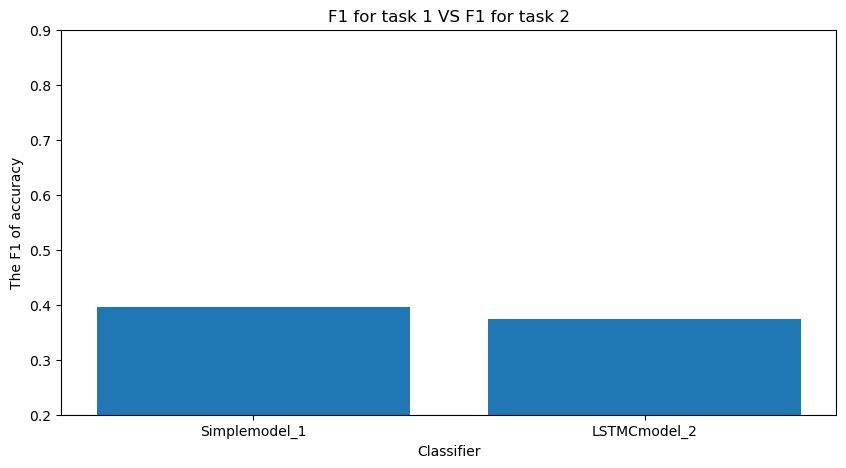

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'Simplemodel_1':f1_score_1, 'LSTMCmodel_2':f1_score_2}
keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
axes = plt.axes()
axes.set_ylim([0.2, 0.9])
# creating the bar plot
plt.bar(keys, values
        )

plt.title('F1 for task 1 VS F1 for task 2')
plt.xlabel("Classifier")
plt.ylabel("The F1 of accuracy")

plt.show()

In [ ]:
print ("Our F1_score in simple model :",f1_score_1)  #report F1 scores for both tasks
print ("Our F1_score in LSTMCmodel :",f1_score_2)

Our F1_score in simple model : 0.39581351094196005
Our F1_score in LSTMCmodel : 0.37387964148527525


### Comment in case 1 and case 2:

- From the graph,We see the performance in both cases didnt performing well as we can see the F1 scores in both models .Due to the limit of the colab and the notebook structure,the memory will lost very quickly if I use too mnay hyperparamters or use too many inputs.I think this is the main reason why the performace is low.It is hard to turn thoese hyperparamters because the sped will become very slow and it is not feasible to do it.

- In Case 1,it looks like that the model is too simple and it cannot capture the pattern.

- In case 2,it look like we cannot find the good hyperparamters within limited resource and time.

- Thershold of F1 score is not easy to choose:it seems it is unlikely we can plug a thershold =0.5(as suggested by some literature) and caluclate the result since the distances structure have complicated relationship (for example if all ap_distance and np_distance are greater less than 0.5,then there is no point to choose such F1 score thershold. Also the distances might depends on the margins values in lost function).In order to explore F1 score,we need to have more time but We have two weeks to do these task which makes this hard to acheieve.




# Task 3 (5 marks): Transformer

Implement a simple Transformer neural network that is composed of the following layers:

* Use BERT as feature extractor for each token.
* A few of transformer encoder layers, hidden dimension 768. You need to determine how many layers to use between 1~3.
* A few of transformer decoder layers, hidden dimension 768. You need to determine how many layers to use between 1~3.
* 1 hidden layer with size 512.
* The final output layer with one cell for binary classification to predict whether two inputs are related or not.

Note that each input for this model should be a concatenation of a positive pair (i.e. question + one answer) or a negative pair (i.e. question + not related sentence). The format is usually like [CLS]+ question + [SEP] + a positive/negative sentence.

Train the model with the training data, use the dev_test set to determine a good size of the transformer layers, and report the final results using the test set. Again, remember to use the test set only after you have determined the optimal parameters of the transformer layers.

Based on your experiments, comment on whether this system is better than the systems developed in the previous tasks.

The breakdown of marks is as follows:

* **1 mark** if the model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes the sentence text to the model correctly. The documentation needs to explain how to handle length difference for a batch of data
* **1 mark** if the code returns the IDs of the *n* sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the transformer layers. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

In [ ]:
!pip install transformers

     ---------------------------------------- 9.1/9.1 MB 29.1 MB/s eta 0:00:00
     ------------------------------------- 287.9/287.9 kB 17.4 MB/s eta 0:00:00
     ---------------------------------------- 401.3/401.3 kB ? eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 47.0 MB/s eta 0:00:00
     ------------------------------------- 316.1/316.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1


#### Use BERT as feature extractor for each token

- in this part we create a dataset for question+ answers pair and label
- we convert into Bert_dataset format and use BertTokenizer to get out inputs.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import precision_score, recall_score, f1_score



def Bert_dataset(x,num):                             #we create a Bert_dataset to do this part: ach input for this model should be a concatenation of a positive pair (i.e. question + one answer)
#or a negative pair (i.e. question + not related sentence). The format is usually like [CLS]+ question + [SEP] + a positive/negative sentence
#num is the number of random sample we want
  data=pd.read_csv(x).sample(num)
  question_input=data["question"].to_list()
  answers_input=data["sentence text"].to_list()
#The format is usually like [CLS]+ question + [SEP] + a positive/negative sentence

  question_encoded= ["[CLS]"+" "+x+" "+"[SEP]"+" " for x in question_input]

  answers_encoded= [x+" "+"[SEP]" for x in answers_input]

  answers_encoded= [x+" "+"[SEP]" for x in answers_input]
  w=[]
  for last, first in zip(question_encoded, answers_encoded):
    w.append(last+first)
#We also write out our label
  label=data["label"].to_list()



  return (w,label)
#we use a function Bert_dataset to return the pair of random X and Y_label we need




In [ ]:
Bert_dataset("training.csv",7) #testing example

(['[CLS] What is marked by DNaseI hypersensitive sites? [SEP] BACKGROUND: Mapping DNaseI hypersensitive sites is commonly used to identify regulatory regions in the genome. [SEP]',
  '[CLS] Which genes have been proposed as potential candidates for gene therapy of heart failure? [SEP] therapeutic activation of YAP or its downstream targets, potentially through AAV-mediated gene therapy, may be a strategy to improve outcome after MI [SEP]',
  '[CLS] Is there an association between FGFR3 mutation and plagiocephaly? [SEP] Between January and December of 1996, patients with a diagnosis of plagiocephaly at the Children&apos;s Hospital of Philadelphia were evaluated for the FGFR3 mutation [SEP]',
  '[CLS] What is the inheritance of hypophosphatemic rickets? [SEP] The study of this family tree strongly suggests an x-linked dominant inheritance. [SEP]',
  "[CLS] What is the function of Oseltamivir when administered during flu? [SEP] Oseltamivir (has known by its brand name 'Tamiflu') is a prod

In [ ]:
train_pairs, train_labels = Bert_dataset('training.csv',5000)   #due to the limit of the memory and other tech issues,we use 5000 datas to train the model only
dev_test_pairs, dev_test_labels = Bert_dataset('dev_test.csv',500)  #create the pair of positive,negative and anchor
test_pairs, test_labels = Bert_dataset('test.csv',500)

In [ ]:
def BertTokenizer_pairs(x, MAX_LEN):                           #we need to tokenize them using Berttokenizer
    Berttokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    output = Berttokenizer(x, return_tensors='tf', max_length=MAX_LEN, padding=True, truncation=True)  #to handle different batch of data,we us padding and truncation
    return output

In [ ]:
MAX_LEN=128  #we set the len to be 128 for the max length for Berttokenizer

#these are out input of three sets of data we need

train_inputs = BertTokenizer_pairs(train_pairs, MAX_LEN)
dev_test_inputs = BertTokenizer_pairs(dev_test_pairs, MAX_LEN)
test_inputs = BertTokenizer_pairs(test_pairs, MAX_LEN)


#### This is the model and part of it I generate from Ai:

- We build up a TransformerEncoderLayer and TransformerDecoderLayer subclass

- Next we build up the whole model which fits the requirements.

In [ ]:
# Custom Transformer layers
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads, ff_dim):
        super(TransformerEncoderLayer, self).__init__()  #super (): we inherit from othe super class layer.
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)  #we set the MultiHeadAttention head with hidden dimention
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),  #we have to create a feed forward loop and ff_dim are the dimentions
            tf.keras.layers.Dense(hidden_dim),
            tf.keras.layers.Dense(hidden_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  #these are the LayerNormalization
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)  #We let our pair of same inputs go into attention layers and it goes into the first LayerNormalization


        out1 = self.layernorm1(inputs + attn_output)
        #We let our pair of same inputs go into attention layers and it goes into the first LayerNormalization
        ffn_output = self.ffn(out1)
        # we feed into feedforward layer
        return self.layernorm2(out1 + ffn_output)  # feed the last output from attention layers with the output from feedforward layer to get final output

class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads, ff_dim):
        super(TransformerDecoderLayer, self).__init__()  #super (): we inherit from othe super class layer.
        self.attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)  #we set the MultiHeadAttentions head with hidden dimention
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'), #we have to create a feed forward loop and ff_dim are the dimentions
            tf.keras.layers.Dense(hidden_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) #these are the LayerNormalization
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self, inputs, enc_outputs):
        attn1 = self.attention1(inputs, inputs)   #We let our pair of same inputs go into attention layers and it goes into the first LayerNormalization

        out1 = self.layernorm1(inputs + attn1)  #We let our pair of same inputs go into attention layers and it goes into the first LayerNormalization
        attn2 = self.attention2(out1, enc_outputs)   #we use our output in encoding layer and feed into second self-attention layer

        out2 = self.layernorm2(out1 + attn2)  #combine together and give output
        ffn_output = self.ffn(out2)   #pass through the feedforword loop

        return self.layernorm3(out2 + ffn_output)  # feed the last out2 with the output from feedforward layer to get final output

class TransformerModel(tf.keras.Model):
  #we build up our final model
    def __init__(self, num_encoder_layers, num_decoder_layers, hidden_dim, ff_dim, hidden_layer_size, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        #this is the pretrained model we use
        self.encoder_layers = [TransformerEncoderLayer(hidden_dim, 4, ff_dim) for _ in range(num_encoder_layers)] #we loop through the number of encoders and decoders
        # the number depends on our choice
        self.decoder_layers = [TransformerDecoderLayer(hidden_dim, 4, ff_dim) for _ in range(num_decoder_layers)]
        self.hidden_layer = tf.keras.layers.Dense(hidden_layer_size, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')  #1 hidden layer with certain sizes
        #final output layer for classifcation: The final output layer with one cell for binary classification to predict whether two inputs are related or not.
    def call(self, inputs, training=False):
        bert_outputs = self.bert(inputs)[0]   #call the inputs[0]

        enc_output = bert_outputs      #the output of the encoder is the input of the decoder
        for encoder in self.encoder_layers:
            enc_output = encoder(enc_output, training=training)   #the data are loop through the number of encoders and decoders

        dec_output = enc_output
        for decoder in self.decoder_layers:
            dec_output = decoder(dec_output, enc_output, training=training)

        hidden_output = self.hidden_layer(tf.reduce_mean(dec_output, axis=1))  #it pass the hidden layers
        output = self.output_layer(hidden_output)  #this return the output
        return output

# These are the paramters we define


hidden_dim = 768  #this is the required numbers
ff_dim = 64    #this is the numbers suggested by professor
hidden_layer_size = 64



#### Finding the best hyperparamters

- In this part we search for different input of parameters and find the best paramters for encoding and decoding layers


- Due to the memory problem,we cannot do too many thing and I just create an example to show this method works

In [ ]:
# we train our model



# we create our dataset objects with traning ,vdalidation and test_dataset in our model
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs['input_ids'], train_labels)).batch(32)
dev_test_dataset = tf.data.Dataset.from_tensor_slices((dev_test_inputs['input_ids'], dev_test_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs['input_ids'], test_labels)).batch(32)

def transformer_tuning(num_encoder_layers, num_decoder_layers):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs['input_ids'], train_labels)).batch(32)
    dev_test_dataset = tf.data.Dataset.from_tensor_slices((dev_test_inputs['input_ids'], dev_test_labels)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs['input_ids'], test_labels)).batch(32)
    transformer_model = TransformerModel(num_encoder_layers, num_decoder_layers,768, 64, 64)
    transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
# we train it with several epoches
    epochs = 2
    transformer_model.fit(train_dataset, validation_data=dev_test_dataset, epochs=epochs)

    return (transformer_model.evaluate(test_dataset)[0],i)



In [ ]:
# we have three trial with different hyperparameters
score_list=[]                         # We want to see determine best performance of each model
for i in [1,2,3]:   #to be simple: I only use the same hyperparamters for each layers # in this task we use 2 layers but it works for 3 layers
  score_list.append(transformer_tuning(i,i))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


157/157 [==============================] - 272s 1s/step - loss: 0.6357 - accuracy: 0.6800 - val_loss: 0.6101 - val_accuracy: 0.6840
Epoch 2/2
16/16 [==============================] - 6s 355ms/step - loss: 0.6222 - accuracy: 0.6660


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


157/157 [==============================] - 301s 1s/step - loss: 0.6324 - accuracy: 0.6796 - val_loss: 0.6107 - val_accuracy: 0.6840
Epoch 2/2
16/16 [==============================] - 7s 462ms/step - loss: 0.6159 - accuracy: 0.6720


In [ ]:
minimum_lost=100000

for i , j in (score_list):   # we search for the best validation minimum losts with the best_praramters
  if i<=minimum_lost:
    best_praramters=j
    minimum_lost=i

best_praramters   #this is the best number of it

2

#### we retrain the model using best hyperparameters and make prediction

- We get the F1 score using inbuit method

-Implement a bb_summariser that returns the  n sentences with highest predicted score.

 - Our code returns the IDs of the  n  sentences that have the highest prediction score in the given question.

In [ ]:
# we train our model
transformer_model = TransformerModel(best_praramters, best_praramters, hidden_dim, ff_dim, hidden_layer_size)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# we create our dataset objects with traning ,vdalidation and test_dataset in our model
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs['input_ids'], train_labels)).batch(32)
dev_test_dataset = tf.data.Dataset.from_tensor_slices((dev_test_inputs['input_ids'], dev_test_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs['input_ids'], test_labels)).batch(32)

# we train it with several epoches
epochs = 2
transformer_model.fit(train_dataset, validation_data=dev_test_dataset, epochs=epochs)

#evaluation
test_loss, test_accuracy = transformer_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

#we compare our F1 score with a test_prediction thershold
test_predictions = transformer_model.predict(test_inputs['input_ids']).flatten()
test_predictions = (test_predictions > 0.5).astype(int)   #these booleans value will be our predicted label

#we need the ground true labels to compare to true labels in F1 score
y_true = np.array(test_labels)
#caluclate our F1 score
f1 = f1_score(y_true, test_predictions)


print(f'F1 Score: {f1}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


157/157 [==============================] - 308s 1s/step - loss: 0.6282 - accuracy: 0.6848 - val_loss: 0.6105 - val_accuracy: 0.6840
Epoch 2/2
16/16 [==============================] - 7s 465ms/step - loss: 0.6188 - accuracy: 0.6800
Test Accuracy: 0.6800000071525574
16/16 [==============================] - 23s 445ms/step
F1 Score: 0.0909090909090909


In [ ]:
def bb_summariser(csvfile, questionids, n=1):
  qid_list=questionids   # The input questionids is a list of question ids.
  test_2 = pd.read_csv(csvfile)   #input file we want
  total=[]

  data=pd.read_csv(csvfile)
  for qid in qid_list:
      target=data.loc[(data["qid"]==qid)]

      answers_input=target["sentence text"].to_list()
      answers_input
      answers_encoded= [x+" "+"[SEP]" for x in answers_input]

      question_input=target["question"].to_list()
      question_encoded= ["[CLS]"+" "+x+" "+"[SEP]"+" " for x in question_input]

      label=target["label"].to_list()

      w=[]
      for last, first in zip(question_encoded, answers_encoded):
          w.append(last+first)

      qid_inputs=BertTokenizer_pairs(w, MAX_LEN)
      value=transformer_model.predict(qid_inputs['input_ids']).flatten()

      list_=list(np.argsort(value))[::-1]

      total.append(list_[0:n])

  return total

In [ ]:
bb_summariser("test.csv",[6,4220],3) # return the highest prediction score based on accuracy. #we use some examples only #inputs are list of iD  #output are the top n sentenses gives
#best accuracy  #I dont have enough RAM to use all texts #but my codes show it works

1/1 [==============================] - 0s 79ms/step


[[28, 16, 29], [0, 1, 4]]

- We plot all results below

In [ ]:
f1_score_3=0.0909090909090909
print ("Our F1 score in transformer is",f1_score_3)

Our F1 score in transformer is 0.0909090909090909


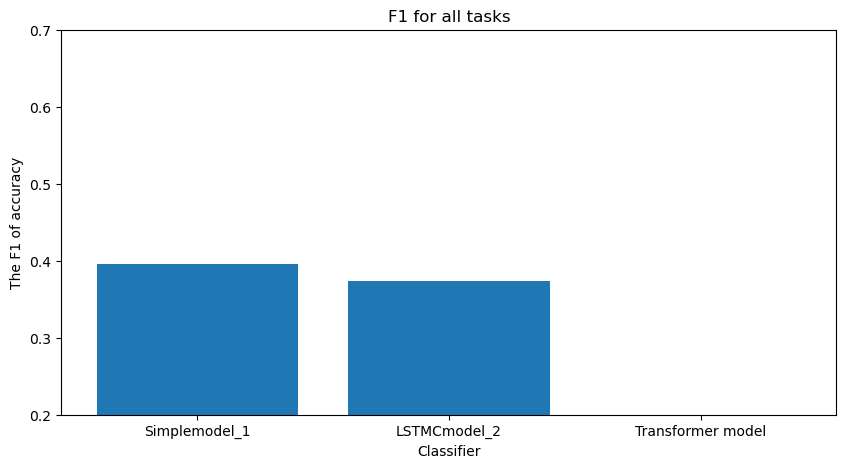

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'Simplemodel_1':f1_score_1, 'LSTMCmodel_2':f1_score_2,'Transformer model':f1_score_3}
keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
axes = plt.axes()
axes.set_ylim([0.2, 0.7])
# creating the bar plot
plt.bar(keys, values
        )

plt.title('F1 for all tasks')
plt.xlabel("Classifier")
plt.ylabel("The F1 of accuracy")

plt.show()

### comment of the result:

- in this task we have tune our models and from the graph we can see the F1 score is very low.It might due to the fact that we didnt choose a proper thereshold value which causes more time to figure out.

- In this task we use fewer data (round thorusand ) and fewer layers due to memory problem. It is clearly the codes are runned sccuessfully however we need to have more exploration of best hyperparamters in future

- it seems the transformer is not useful under this construction and I spend lot of hours to run and test it
- if we have more time,we can build up a better one

- In conclusion: few data and few layers (or didnt get the correct layers) might be the problem.



# Submission

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook as text cells. **The notebook should contain the output of the runs. All code should run. Code with syntax errors or code without output will not be assessed.**

**Do not submit multiple files.**

Examine the text cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this useful [guide to the MarkDown notation](https://daringfireball.net/projects/markdown/syntax),  which explains the format of the text cells.

- Question 3: Part of the transformer codes are from AI /other source
- Question 1 and 2: for the part in building up the custom model(e.g custom training loop) ,i actually try to understand the code from this website:

https://keras.io/examples/vision/siamese_network/
